In [50]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
%matplotlib inline

In [51]:
def read_data(read_file):
#     df = pd.read_csv(read_file, low_memory=False, header=None)
#     df.columns = ["Timestamp", "LineID", "JourneyPatternID", "TimeFrame", 
#                   "VehicleJourneyID", "Lon", "Lat", "VehicleID", "StopID", 
#                   "AtStop", "HumanTime", "Day", "Hour", "JourneyGroup", "Runtime"]

    df = pd.read_csv(read_file, low_memory=False)
    
    return df

In [52]:
def read_schedule(schedule_file):
    schedule = pd.read_csv(schedule_file, low_memory=False, encoding="ISO-8859-1")
    
    return schedule


In [53]:
def clean_df(df):
    # Dropping null values
    df = df.dropna()
    
    # Convert LineID to str
    df['LineID'] = df['LineID'].astype('str')
    
    return df


In [61]:
def clean_schedule(schedule):
    
    # drop null values
    schedule.dropna(0, inplace=True)
    
    # extract StopID
    schedule["StopID"] = schedule['stop_id'].apply(lambda x: x[-4:])
    
    # Convert StopIDs back to int
    schedule['StopID'] = schedule['StopID'].astype('int64')
    
    # Extracting LineID from trip_id
    schedule["LineID"] = schedule["trip_id"].str.extract('\-(.*?)\-')
    
    # Extracting direction from trip_id
    schedule["Direction"] = schedule['trip_id'].apply(lambda x: x[-1:])
    
    # Dropping non-major journeypatterns
    schedule = schedule[(schedule.Direction == "I") | (schedule.Direction == "O")]
    
    # Converting Direction to JourneyPatternID
    schedule["JourneyPatternID"] = schedule['Direction'].apply(lambda x: "1001" if x == "I" else "0001")
    schedule['JourneyPatternID'] = schedule['JourneyPatternID'].astype('int64')
    
    schedule = schedule[~((schedule['Name without locality'].str.contains("set down")) | 
                  (schedule['Name without locality'].str.contains("Set Down")) | 
                  (schedule['Name without locality'].str.contains("Fake")) | 
                  (schedule['Name'].str.contains("Fake")) | 
                  (schedule['Name without locality'].str.contains("Virtual")) |
                  (schedule['Name'].str.contains("Virtual")))]
            
    # Renaming 'Long' to 'Lon'
    schedule = schedule.rename(columns={'Long': 'Lon'})
    
    return schedule

In [55]:
def get_common_stops(df, schedule, common_stops):
    line = str(df['LineID'].iloc[0])
#     line = df['LineID'].iloc[0]

    
    print(line)
    
    schedule_in = schedule[(schedule.LineID == line) & (schedule.JourneyPatternID == 1001)]
    schedule_out = schedule[(schedule.LineID == line) & (schedule.JourneyPatternID == 1)]
    df_1001 = df[df.JourneyPatternID == 1001]
    df_0001 = df[df.JourneyPatternID == 1]

    stops_in = set(schedule_in.StopID.unique())
    stops_out = set(schedule_out.StopID.unique())

    stops_1001 = set(df_1001.StopID.unique())
    stops_0001 = set(df_0001.StopID.unique())
    
    print("Difference 1001", len(stops_in ^ stops_1001))
    print("Difference 0001", len(stops_out ^ stops_0001))
    
    instops = stops_in & stops_1001
    outstops = stops_out & stops_0001

    allstops = instops | outstops
    
    print(len(allstops))
    print(len(common_stops))
    
    return (allstops | common_stops)
    

In [56]:
def save_stops(schedule, stops, write_file):
    stops = list(stops)
    schedule = schedule[['Name without locality','Name','Lat','Lon','StopID',]]
    schedule = schedule.drop_duplicates()
    schedule = schedule[schedule.StopID.isin(stops)]
    
#     schedule = schedule[~((schedule['Name without locality'].str.contains("set down")) | 
#                   (schedule['Name without locality'].str.contains("Set Down")) | 
#                   (schedule['Name without locality'].str.contains("Fake")) | 
#                   (schedule['Name'].str.contains("Fake")) | 
#                   (schedule['Name without locality'].str.contains("Virtual"))
#                   (schedule['Name'].str.contains("Virtual"))
#                          )]
    
    schedule.to_csv(write_file)

In [57]:
def main(read_directory, schedule_file, write_file):
    
    schedule = read_schedule(schedule_file)
    schedule = clean_schedule(schedule)
    
    common_stops = set()
    
    for read_file in os.listdir(read_directory):
        if read_file.endswith(".csv"):
            print("Reading", read_file, "from", read_directory)
            
            df = read_data(read_directory + read_file)
            df = clean_df(df)
            common_stops = get_common_stops(df, schedule, common_stops)
            
        print("Finished", read_file)
        print()
        
    save_stops(schedule, common_stops, write_file)

    print("Finished main!")    

In [62]:
# read_directory = "bus_data/clean_data3/"
read_directory = "bus_data/clean_data_final/"
# read_directory = "bus_data/clean_data_rough/"



schedule_file = 'bus_data/dublinbus_scheduledData2013csv.csv'
write_file = 'bus_data/static_data3/stops.csv'

main(read_directory, schedule_file, write_file)

/Users/danieljordan/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:13: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)


Finished .DS_Store

Reading 1.csv from bus_data/clean_data_final/
1
Difference 1001 1
Difference 0001 0
81
0
Finished 1.csv

Reading 102.csv from bus_data/clean_data_final/
102
Difference 1001 2
Difference 0001 0
100
81
Finished 102.csv

Reading 104.csv from bus_data/clean_data_final/
104
Difference 1001 2
Difference 0001 0
62
181
Finished 104.csv

Reading 11.csv from bus_data/clean_data_final/
11
Difference 1001 2
Difference 0001 4
118
232
Finished 11.csv

Reading 111.csv from bus_data/clean_data_final/
111
Difference 1001 0
Difference 0001 1
48
331
Finished 111.csv

Reading 114.csv from bus_data/clean_data_final/
114
Difference 1001 1
Difference 0001 1
54
379
Finished 114.csv

Reading 116.csv from bus_data/clean_data_final/
116
Difference 1001 7
Difference 0001 6
100
430
Finished 116.csv

Reading 118.csv from bus_data/clean_data_final/
118
Difference 1001 8
Difference 0001 0
34
506
Finished 118.csv

Reading 120.csv from bus_data/clean_data_final/
120
Difference 1001 12
Difference 000

In [255]:
# # read_directory = "bus_data/clean_data3/"
# read_directory = "bus_data/clean_location_data/"
# # read_directory = "bus_data/clean_data_rough/"



# schedule_file = 'bus_data/dublinbus_scheduledData2013csv.csv'
# write_file = 'bus_data/static_data2/stops.csv'

# main(read_directory, schedule_file, write_file)

/Users/danieljordan/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:13: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)


Finished .DS_Store

Reading 1.csv from bus_data/clean_location_data/
1
Difference 1001 9
Difference 0001 6
81
0
Finished 1.csv

Reading 104.csv from bus_data/clean_location_data/
104
Difference 1001 4
Difference 0001 0
62
81
Finished 104.csv

Reading 11.csv from bus_data/clean_location_data/
11
Difference 1001 9
Difference 0001 13
118
132
Finished 11.csv

Reading 111.csv from bus_data/clean_location_data/
111
Difference 1001 11
Difference 0001 11
48
231
Finished 111.csv

Reading 114.csv from bus_data/clean_location_data/
114
Difference 1001 3
Difference 0001 4
54
279
Finished 114.csv

Reading 116.csv from bus_data/clean_location_data/
116
Difference 1001 7
Difference 0001 6
100
330
Finished 116.csv

Reading 118.csv from bus_data/clean_location_data/
118
Difference 1001 8
Difference 0001 0
34
406
Finished 118.csv

Reading 120.csv from bus_data/clean_location_data/
120
Difference 1001 15
Difference 0001 14
50
418
Finished 120.csv

Reading 123.csv from bus_data/clean_location_data/
123
Di

In [256]:
read_directory = "bus_data/clean_data3/"
# read_directory = "bus_data/clean_location_data/"
# read_directory = "bus_data/clean_data_rough/"



schedule_file = 'bus_data/dublinbus_scheduledData2013csv.csv'
write_file = 'bus_data/static_data2/stops_wrong.csv'

main(read_directory, schedule_file, write_file)

/Users/danieljordan/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:13: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)


Finished .DS_Store

Reading 1.csv from bus_data/clean_data3/
1
Difference 1001 6
Difference 0001 0
81
0
Finished 1.csv

Reading 104.csv from bus_data/clean_data3/
104
Difference 1001 2
Difference 0001 31
31
81
Finished 104.csv

Reading 11.csv from bus_data/clean_data3/
11
Difference 1001 64
Difference 0001 4
58
107
Finished 11.csv

Reading 111.csv from bus_data/clean_data3/
111
Difference 1001 8
Difference 0001 9
48
155
Finished 111.csv

Reading 114.csv from bus_data/clean_data3/
114
Difference 1001 30
Difference 0001 1
27
203
Finished 114.csv

Reading 116.csv from bus_data/clean_data3/
116
Difference 1001 12
Difference 0001 8
93
229
Finished 116.csv

Reading 118.csv from bus_data/clean_data3/
118
Difference 1001 8
Difference 0001 0
34
313
Finished 118.csv

Reading 120.csv from bus_data/clean_data3/
120
Difference 1001 13
Difference 0001 13
50
325
Finished 120.csv

Reading 123.csv from bus_data/clean_data3/
123
Difference 1001 1
Difference 0001 0
90
375
Finished 123.csv

Reading 13.csv

## rough work

In [257]:
line = '16'

read_directory = "bus_data/clean_location_data/"

schedule = read_schedule(schedule_file)
schedule = clean_schedule(schedule)

df = read_data(read_directory + line + ".csv")
df = clean_df(df)

/Users/danieljordan/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:13: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)


In [268]:

schedule_in = schedule[(schedule.LineID == line) & (schedule.JourneyPatternID == 1001)]
schedule_out = schedule[(schedule.LineID == line) & (schedule.JourneyPatternID == 1)]
df_1001 = df[df.JourneyPatternID == 1001]
df_0001 = df[df.JourneyPatternID == 1]


stops_in = set(schedule_in.StopID.unique())
stops_out = set(schedule_out.StopID.unique())

stops_1001 = set(df_1001.StopID.unique())
stops_0001 = set(df_0001.StopID.unique())

In [269]:
print(sorted(stops_in ^ stops_1001))
print(sorted(stops_out ^ stops_0001))

[45, 205, 262, 270, 1323, 1339, 2966, 2968, 3669]
[10, 208, 209, 210, 211, 212, 213, 215, 216, 217, 218, 219, 226, 227, 228, 229, 230, 1285, 1330, 1357, 1631, 1641, 1642, 2976, 2977, 2978, 2981, 2991, 5171, 7349]


In [270]:
print(sorted(stops_in))

[10, 12, 14, 15, 17, 18, 19, 21, 85, 203, 204, 205, 215, 216, 217, 218, 219, 220, 221, 278, 320, 1325, 1326, 1327, 1328, 1329, 1330, 1331, 1332, 1333, 1334, 1335, 1336, 1337, 1338, 1339, 1340, 1341, 1342, 1343, 1344, 1345, 1347, 1348, 1349, 1350, 1352, 1353, 1354, 1355, 1357, 1359, 1622, 1623, 1624, 1625, 1626, 1627, 1628, 1629, 1630, 2976, 2977, 2978, 2979, 2980, 2981, 2991, 2992, 5171, 7293, 7347]


In [271]:
print(sorted(stops_1001))

[10, 12, 14, 15, 17, 18, 19, 21, 45, 85, 203, 204, 215, 216, 217, 218, 219, 220, 221, 262, 270, 278, 320, 1323, 1325, 1326, 1327, 1328, 1329, 1330, 1331, 1332, 1333, 1334, 1335, 1336, 1337, 1338, 1340, 1341, 1342, 1343, 1344, 1345, 1347, 1348, 1349, 1350, 1352, 1353, 1354, 1355, 1357, 1359, 1622, 1623, 1624, 1625, 1626, 1627, 1628, 1629, 1630, 2966, 2968, 2976, 2977, 2978, 2979, 2980, 2981, 2991, 2992, 3669, 5171, 7293, 7347]


In [272]:
print(sorted(stops_out))

[44, 45, 46, 47, 48, 49, 50, 51, 52, 119, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 262, 270, 336, 1279, 1282, 1284, 1285, 1287, 1288, 1289, 1290, 1291, 1292, 1293, 1294, 1295, 1296, 1297, 1298, 1299, 1300, 1301, 1302, 1303, 1304, 1305, 1320, 1321, 1322, 1323, 1324, 1631, 1632, 1633, 1634, 1635, 1636, 1637, 1638, 1639, 1640, 1641, 1642, 2966, 2967, 2968, 2969, 2970, 2971, 2975, 3669, 4432, 4456, 5051, 5052, 5053, 7068, 7347, 7349]


In [273]:
print(sorted(stops_0001))

[10, 44, 45, 46, 47, 48, 49, 50, 51, 52, 119, 214, 231, 232, 233, 234, 235, 236, 237, 262, 270, 336, 1279, 1282, 1284, 1287, 1288, 1289, 1290, 1291, 1292, 1293, 1294, 1295, 1296, 1297, 1298, 1299, 1300, 1301, 1302, 1303, 1304, 1305, 1320, 1321, 1322, 1323, 1324, 1330, 1357, 1632, 1633, 1634, 1635, 1636, 1637, 1638, 1639, 1640, 2966, 2967, 2968, 2969, 2970, 2971, 2975, 2976, 2977, 2978, 2981, 2991, 3669, 4432, 4456, 5051, 5052, 5053, 5171, 7068, 7347]


In [ ]:
# 10, 208, 209, 210, 211, 212, 213, 215, 216, 217, 218, 219, 226, 227, 228, 229, 230, 1285, 1330, 1357, 1631, 1641, 1642, 2976, 2977, 2978, 2981, 2991, 5171, 7349

In [264]:
schedule_out

,trip_id,arrival_time,departure_time,stop_id,Name without locality,Name,Lat,Lon,stop_sequence,stop_headsign,shape_dist_traveled,StopID,LineID,Direction,JourneyPatternID
72410,11102.2213.0-16-b12-1.158.O,06:30:00,06:30:00,8240DB007347,Bus Interchange,Airport,53.428020,-6.242021,1,Ballinteer,0.000000,7347,16,O,1
72411,11102.2213.0-16-b12-1.158.O,06:31:58,06:31:58,8240DB003669,Clarion Hotel,Airport Nth Rd,53.428456,-6.235065,2,Ballinteer,680.709367,3669,16,O,1
72412,11102.2213.0-16-b12-1.158.O,06:33:06,06:33:06,8240DB007349,Great Southern Hotel,Airport,53.425278,-6.234700,3,Ballinteer,1287.406131,7349,16,O,1
72413,11102.2213.0-16-b12-1.158.O,06:34:30,06:34:30,8240DB001631,ALSAA Sports Club,Swords Road,53.421680,-6.231434,4,Ballinteer,2160.022743,1631,16,O,1
72414,11102.2213.0-16-b12-1.158.O,06:34:53,06:34:53,8240DB001632,Toberbunny Lodge,Swords Road,53.420500,-6.233108,5,Ballinteer,2332.223208,1632,16,O,1
72415,11102.2213.0-16-b12-1.158.O,06:35:22,06:35:22,8240DB005053,Airport Runway,Swords Road,53.419132,-6.235451,6,Ballinteer,2549.447626,5053,16,O,1
72416,11102.2213.0-16-b12-1.158.O,06:35:51,06:35:51,8240DB001633,Cemetery,Swords Road,53.417782,-6.237719,7,Ballinteer,2762.646800,1633,16,O,1
72417,11102.2213.0-16-b12-1.158.O,06:37:00,06:37:00,8240DB001634,Cemetery,Swords Road,53.413521,-6.238888,8,Ballinteer,3272.574253,1634,16,O,1
72418,11102.2213.0-16-b12-1.158.O,06:37:20,06:37:20,8240DB001635,Sports Ground,Swords Road,53.411696,-6.238858,9,Ballinteer,3476.927208,1635,16,O,1
72419,11102.2213.0-16-b12-1.158.O,06:38:00,06:38:00,8240DB001636,Turnapin Lane,Swords Road,53.408244,-6.237587,10,Ballinteer,3873.223269,1636,16,O,1


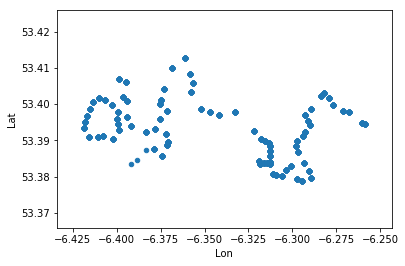

In [245]:
plotdf = schedule_out[["Lon", "Lat"]]
plotdf.plot.scatter(x="Lon", y="Lat")

In [238]:
df.JourneyPatternID.unique()

array([   1, 1001])

In [239]:
schedule_in.dtypes


trip_id                   object
arrival_time              object
departure_time            object
stop_id                   object
Name without locality     object
Name                      object
Lat                      float64
Lon                      float64
stop_sequence              int64
stop_headsign             object
shape_dist_traveled      float64
StopID                     int64
LineID                    object
Direction                 object
JourneyPatternID           int64
dtype: object

In [240]:
df_1001.dtypes

Timestamp             int64
LineID               object
JourneyPatternID      int64
TimeFrame            object
VehicleJourneyID      int64
Lon                 float64
Lat                 float64
VehicleID             int64
StopID                int64
AtStop                int64
HumanTime            object
Day                   int64
Hour                  int64
JourneyGroup         object
Runtime               int64
dtype: object